# Prueba 2 - análisis de revisiones positivas y negativas

# Introducción

El objetivo es identificar cuando una reseña es positiva o negativa, para esto se realiza una exploracion de los datos dados, se hace limpieza y tratamiento de los datos con el objetivo de usarlos para generar un modelo que pueda predecir si la reseña es positiva o negativa.

In [1]:
# cargando liberías básicas de procesamiento de DataFrames y de texto
import numpy as np
import pandas as pd
import spacy
import string
import re

from sklearn.model_selection import train_test_split
from spacy.tokens import DocBin

In [2]:
df_rev = pd.read_csv('NLP prueba 2.csv', index_col=0)
df_rev

,text,tag
0,"in exotica everybody is watching , and what is...",pos
1,some of the gags are so carefully innocuous th...,neg
2,press junkets are a haven for control freaks .,neg
3,"then i realized he was , and i was watching it .",neg
4,uh huh .,neg
...,...,...
29405,"roro ( nicknamed "" jalla "" ) is having family ...",neg
29406,"in three days time , or something .",neg
29407,director nicholas hytner is guilty of encourag...,neg
29408,neighbor runs a small failing grocery store .,neg


Como las revisiones se encuentran en inglés, se carga el módulo de la librería de este lenguaje

In [3]:
nlp = spacy.load('en_core_web_sm')

stopwords = spacy.lang.en.stop_words.STOP_WORDS
punctuation = string.punctuation

# Análisis exploratorio

La parte más importante de la clasificación se encuentra en la revisión de la información y la limpieza de los datos. 

En primer lugar se revisa si hay información faltante.

In [4]:
print('Valores faltantes por columnas del DataFrame:')
df_rev.isna().sum()

Valores faltantes por columnas del DataFrame:


text    17
tag      8
dtype: int64

In [5]:
# Revisando las opiniones sin etiqueta
df_rev[df_rev.tag.isna()]

,text,tag
904,"A grandly ambitious, warmhearted, wildly uneve...",NaN
1137,"Stunning visuals and imagery, exceptional dire...",NaN
3936,If only the scares were better.,NaN
3975,Candyman bolsters an already robust mythos wit...,NaN
5011,"In short, a turkey.",NaN
13436,The film's disarming romcom sensibilities are ...,NaN
20433,I found this movie to be very engrossing and e...,NaN
26480,this movie is a complete joke,NaN


La información faltante es pequeña en comparacion al número total de revisiones. 

Del total, hay 17 opiniones faltantes, algunas de las cuales tienen su etiqueta de positiva o negativa. Esta es una característica esencial, con etiqueta pero sin la opinión es inútil tomar esas muestras y no hay forma de completar esta información. Por otro lado sería posible asignar manualmente una etiqueta a partir del contenido, siempre y cuando el número de muestras sin etiquetas pero con texto sea bajo. En big data podría entrenarse el modelo **sin estos datos**, alcanzar un buen desempeño en datos de entrenamiento, y luego etiquetar las muestras faltantes. 

En este caso no se asignan etiquetas ya que es lo que se haría en un modelo de big data.

## Distribucion de las etiquetas

Para el análisis y posterior entrenamiento de modelos es importante evaluar la distribución de las categorías, si una categoría es abrumadoramente mayoritaria este será un elemento relevante para el proceso de análisis y desarrollo del modelo de predicción. Una distribución muy desigual puede llevar a un modelo predictivo a ignorar la categoría minoritaria.

In [6]:
cat_dist = df_rev.tag.value_counts()
print(cat_dist)
print(f'\nDistribución de categorias \n Positivas: {cat_dist[1]/(np.sum(cat_dist)):.3f}, Negativas: {cat_dist[0]/(np.sum(cat_dist)):.3f}')

neg    25434
pos     3968
Name: tag, dtype: int64

Distribución de categorias 
 Positivas: 0.135, Negativas: 0.865


De esta forma es posible obtener información relevante, el 87% de las opiniones registradas fueron etiquetadas como negativas. Para entrenar un modelo debe usarse alguno de los métodos que lidian con imbalances, ya sea a través de métodos como el uso pesos, la reducción de la categoría mayoritaria, o la creación de nuevas muestras minoritarias (aunque en este caso es difícil). Un modelo incapaz de discriminar categorías tendría una exactitud de 87% si etiqueta todas las opiniones como negativas.

## Longitud en palabras

En el análisis de texto, a menudo es útil revisar el número de palabras de cada opinión, a continuacion se muestra la distribución del número de palabras en los datos provistos.

In [7]:
# se crea una columna nueva con el número de palabras del texto, separadas por espacio
df_rev['words'] = df_rev.text.apply(lambda x : len( str(x).split() ) )

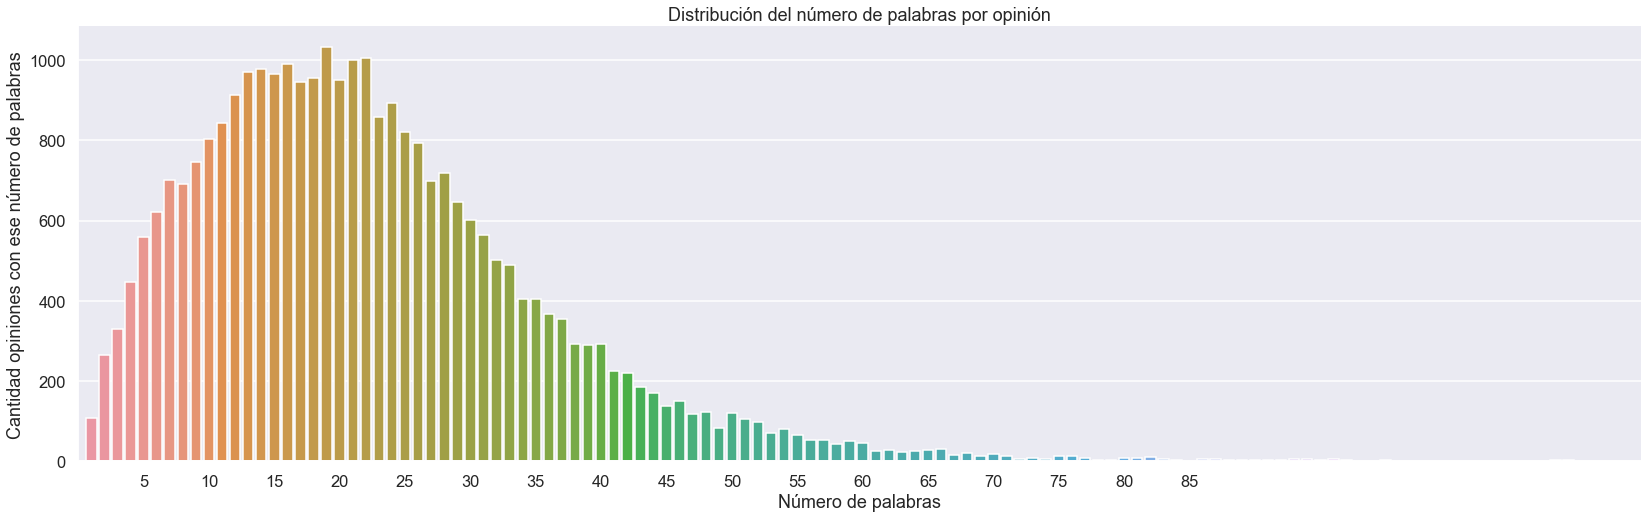

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df_wc = df_rev.groupby('words').size()

sns.set_context('talk')
sns.set_style('darkgrid')

plt.figure(figsize=(28,8))
plt.title("Distribución del número de palabras por opinión")
sns.barplot(x=df_wc.index, y=df_wc.values)
plt.xticks([i-1 for i in range(0,90) if i%5==0])
plt.xlabel("Número de palabras")
plt.ylabel("Cantidad opiniones con ese número de palabras")
sns.despine()
plt.show()

In [9]:
# una descripcion estadística del número de palabras encontrado
df_rev.words.describe()

count    29410.000000
mean        22.403094
std         13.516609
min          1.000000
25%         13.000000
50%         20.000000
75%         29.000000
max        179.000000
Name: words, dtype: float64

In [10]:
# revisando las opiniones con menos palabras
df_rev[(df_rev.words<=3)].text

4              uh huh .
25                why ?
35               ummm !
105               fun ?
116      or substance .
              ...      
29203     challenging ?
29304        honestly .
29318         if only .
29322      piano duel ?
29348       and gordy !
Name: text, Length: 702, dtype: object

Las **opiniones más cortas carecen de sentido**, por lo que puede mejorar el desempeño del algoritmo si estas se eliminan.

In [11]:
# revisando las opiniones con más palabras
df_rev[(df_rev.words>150)].text

6785     the film gives us charlton heston ( in one of ...
23995    since that plot is incredibly lame and a track...
27929    after the setup , in which the robinson family...
Name: text, dtype: object

In [12]:
# tomando un ejemplo
df_rev[(df_rev.words>150)].text.iloc[2]

'after the setup , in which the robinson family--father john ( william hurt , looking and sounding as spaced out as he does in interviews ) , mother maureen ( rogers , wasted ) , daughters judy ( heather graham , ditto ) and penny ( a heavily made-up chabert , looking like a junior version of neve campbell in wild things ) , and son will ( young newcomer johnson , making the best of it ) --and pilot don west ( leblanc , doing a bad han solo impression ) find themselves lost in space after their ship is sabotaged by evil stowaway dr . smith ( a watered-down but still-lively oldman , cashing a paycheck and loving every minute ) , the script\'s " stream " of events becomes so fragmented and random that it seems to be made up as it goes along--and hopkins does little to make what does go on the slightest bit interesting .'

Al mirar las **opiniones más largas**, son pocas y parecen ser válidas, por lo que no sería recomendable removerlas.

In [13]:
def common_words(df, user_list=[]):
    from collections import Counter
    word_count = Counter()
    for review in df.text:
        texto = review.split()   # esto se podria hacer tokenizando
        for word in texto:
            if word in [*stopwords, *punctuation, *user_list]: continue
            word_count[word] += 1
    return word_count

In [14]:
cw = common_words(df_rev[df_rev.tag==1])
cw.most_common(15)

[]

In [15]:
common_pos = [tupl[0] for tupl in cw.most_common(25)]

cw = common_words(df_rev[df_rev.tag==0], common_pos)
cw.most_common(15)

[]

# Limpieza de datos

## Transformaciones para entrenamiento

In [16]:
print(df_rev) # original

# eliminando valores faltantes
df_rev = df_rev.dropna()

# eliminando muestas con bajo numero de palabras
df_rev = df_rev[(df_rev.words>3)]

# codificacion one hot para entrenar los modelos
tag_onehot = {'pos':1, 'neg':0}
df_rev.tag = df_rev.tag.replace(tag_onehot)

print(df_rev) # luego de las transformaciones

                                                    text  tag  words
0      in exotica everybody is watching , and what is...  pos     14
1      some of the gags are so carefully innocuous th...  neg     11
2         press junkets are a haven for control freaks .  neg      9
3       then i realized he was , and i was watching it .  neg     12
4                                               uh huh .  neg      3
...                                                  ...  ...    ...
29405  roro ( nicknamed " jalla " ) is having family ...  neg     12
29406                in three days time , or something .  neg      8
29407  director nicholas hytner is guilty of encourag...  neg     31
29408      neighbor runs a small failing grocery store .  neg      8
29409  what i admire most about city of angels is its...  pos     13

[29410 rows x 3 columns]
                                                    text  tag  words
0      in exotica everybody is watching , and what is...    1     14
1      s

## Pipeline

A continuación se definen las funciones de preprocesamiento y de generación de los archivos que necesita spacy

In [17]:
def remove_url(txt):
    txt = re.sub(r"https?:\S*", "", txt, flags=re.MULTILINE)
    return txt


def clean_text(txt):
    return " ".join(clean_tokenizer(txt))


def clean_tokenizer(txt):
    """
    Given a string, tokenizes the string, with lower case, no stopwords and no punctuation
    
    Input:
     - string
     
    Output:
     - list of tokenized words
    """
    txt = remove_url(txt)
    txt = nlp(txt)
    
    # lematizacion y remocion de stopwords
    tokens = [word.lemma_.lower().strip() for word in txt if word not in [*stopwords,*punctuation]]
    
    return tokens


def make_docs(df):
    """
    Transforms data into spacy documents
    
    Input:
     - data: is a dataframe with 'text' and 'tag' columns
     
    Output:
     - docs: a list of spacy tokens.doc.Doc, which are objects with the attributes needed by spacy
     - data_train: preprocessed DataFrame
     
    """
    docs = []
    
    # preprocessing
    df.text = df.text.apply(clean_text)
    
    # turning data into tuples
    data = tuple( zip( df.text.tolist(), data.tag.to_list() ) )
    
    # appending the object spacy.token.doc.Doc into a list
    for doc, label in nlp.pipe(data, as_tuples=True):
        doc.cats['positive'] = label
        doc.cats['negative'] = 1 ^ label  # negacion XOR
        docs.append(doc)
        
    return docs, data

In [18]:
# separando dataset en entrenamiento y test
df_train, df_test = train_test_split(df_rev, test_size=0.2)

In [19]:
# pasando los DataFrames a través del preprocesamiento y obteniendo los objetos de spacy
train_docs, train_data = make_docs(df_train)
test_docs, test_data = make_docs(df_test)

TypeError: Argument 'other' has incorrect type (expected spacy.tokens.token.Token, got str)

In [ ]:
# creando los archivos de spacy en disco
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./spacy_data/text_train.spacy")

doc_bin = DocBin(docs=test_docs)
doc_bin.to_disk("./spacy_data/text_test.spacy")

In [ ]:
nlp.pipe_names

In [ ]:
!python -m spacy init fill-config ./spacy_data/base_config.cfg ./spacy_data/config.cfg

In [ ]:
# !python -m spacy train ./spacy_data/config.cfg --output ./spacy_data/output --paths.train ./spacy_data/text_train.spacy --paths.dev ./spacy_data/text_test.spacy

# Resultado del entrenamiento de spacy

In [ ]:
# cargando el mejor modelo entrenado
nlp = spacy.load('./spacy_data/output/model-best')

text = input("Please input a review: ")
doc = nlp(text)
if doc.cats['positive']>0.5:
    print("Positive review")
else:
    print("Negative review")

Spacy es una buena libería para procesamiento de textos, pero aún así el costo computacional es alto y se favorece mucho por el suo de GPU. Además el manejo de la libería con datasets imbalanceados se hace un poco más complicado. 

# Usando otros modelos
Es posible usar spacy para el preprocesamiento y otras liberías para el entrenamiento de modelos, lo que puede favorecer el trabajo con otros ingenieros y el uso de herramientas adicionales.

## Regresión logística

La regresión logística es un modelo estadístico sencillo que permite obtener la probabilidad de que una muestra pertenezca a una categoría. El modelo original se implementa para categorías binarias lo que funciona perfecto en este caso

In [ ]:
X_train = df_train.filter(['text','tag'])
y_train = X_train.pop('tag')

X_test = df_test.filter(['text','tag'])
y_test = X_test.pop('tag')

In [ ]:
X_train

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline


class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return {}


from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

bow_vector = CountVectorizer( tokenizer = clean_tokenizer, ngram_range=(1,1) )
tfidf_vector = TfidfVectorizer( tokenizer = clean_tokenizer )

pipe = Pipeline([( "cleaner", predictors() ),
                 ( "vecorizer", bow_vector), 
                 ( "classifier", classifier )])

pipe.fit(df_train, df_train)

## Deep learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences